<a href="https://colab.research.google.com/github/tomdyer10/wine_expert/blob/master/train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a classification model to predict the 'country - region' of a wine based on the description of that wine. Model was built using the Fast AI API. For the purposes of this project, state of the art performance is not necessary, so I did not spend. too much time tuning performance.

Data is from the Kaggle Wine Reviews dataset.

Dataset had high cardinality so for the purpose of this exercise, classes were reduced to only countries and regions with a high number of examples in this dataset.

# Load & Process Data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *

In [2]:
import pandas as pd
df = pd.read_csv('drive/My Drive/wine_reviews/data/winemag-data-130k-v2.csv', index_col=None)
df = df.drop(['Unnamed: 0'], axis=1); df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
#filter to only countries with over 10k wines in dataset  
df1 =  df[df['country'].map(df['country'].value_counts()) > 10000]
df1['country'].value_counts()

US        54504
France    22093
Italy     19540
Name: country, dtype: int64

In [0]:
df1 = df1.dropna(axis=1).reset_index(drop=True)


Creating a new category, a combination of country and wine province and only returning categories with more than 100 items.

In [0]:
import numpy as np

def categorise(country, province):
  str_ = country + ' - ' + province
  return str_

df1['category'] = np.vectorize(categorise)(df1['country'], df1['province'])
df1['category'].value_counts()

df2 =  df1[df1['category'].map(df1['category'].value_counts()) > 100]

In [8]:
df_cat = df2[['description', 'category']]
df_cat.columns = ['text', 'target']; df_cat.head()

,text,target
0,"Aromas include tropical fruit, broom, brimston...",Italy - Sicily & Sardinia
1,"Tart and snappy, the flavors of lime flesh and...",US - Oregon
2,"Pineapple rind, lemon pith and orange blossom ...",US - Michigan
3,"Much like the regular bottling from 2012, this...",US - Oregon
4,"Here's a bright, informal red that opens with ...",Italy - Sicily & Sardinia


In [9]:
df_cat['target'].nunique()

27

In [10]:
df_cat.shape

(95650, 2)

We now have a dataset ready for training, with 95,650 wine descriptions assigned to 27 different categories

# Language Model

Training a language model using the FastAI API

In [11]:
#make databunch for language model
seed = 42
data = (TextList.from_df(df_cat,).split_by_rand_pct(0.1, seed).label_for_lm().databunch(bs=24))

In [12]:
data.show_batch(2)

idx,text
0,"steel fermented . xxbos xxmaj pineapple rind , lemon pith and orange blossom start off the aromas . xxmaj the palate is a bit more opulent , with notes of honey - drizzled guava and mango giving way to a slightly astringent , semidry finish . xxbos xxmaj much like the regular bottling from 2012 , this comes across as rather rough and tannic , with rustic , earthy ,"
1,"just a bit too heavy for the wine that 's in the glass . xxbos xxmaj fermented and aged in stainless steel , this is a lightly aromatic xxmaj gris with red apple and apple blossom . xxmaj it 's full bodied with a touch of residual sugar and a zip of acidity . a light ale note makes it seem not entirely finished . xxbos xxmaj the 2010 xxmaj"


In [13]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [0]:
# learner.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

In [0]:
# learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

Model achieved performance of over 40%, this is a good performance for a model of this type so I did not perform any further training.

In [0]:
#save to notebook instance and my google drive
# learner.save_encoder('regional_encoder')
# learner.save_encoder('../drive/My Drive/wine_reviews/models/regional_encoder')

Load saved model from drive

In [15]:
learner.load_encoder('../drive/My Drive/wine_reviews/models/regional_encoder')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (86085 items)
x: LMTextList
xxbos xxmaj aromas include tropical fruit , broom , brimstone and dried herb . xxmaj the palate is n't overly expressive , offering unripened apple , citrus and dried sage alongside brisk acidity .,xxbos xxmaj tart and snappy , the flavors of lime flesh and rind dominate . xxmaj some green pineapple pokes through , with crisp acidity underscoring the flavors . xxmaj the wine was all stainless - steel fermented .,xxbos xxmaj pineapple rind , lemon pith and orange blossom start off the aromas . xxmaj the palate is a bit more opulent , with notes of honey - drizzled guava and mango giving way to a slightly astringent , semidry finish .,xxbos xxmaj much like the regular bottling from 2012 , this comes across as rather rough and tannic , with rustic , earthy , herbal characteristics . xxmaj nonetheless , if you think of it as a pleasantly unfussy country wine , it 's a good companion to a hearty winter stew 

Testing language model predictions when given a preceding phrase, temperature set to 0.75 to give some randomness in response.

In [16]:
TEXT = "This french red wine"
N_WORDS = 40
N_SENTENCES = 2

learner.predict(TEXT, N_WORDS, temperature=0.75)

'This french red wine is also full of red fruits , leaving a soft , smooth , rounded feel . The wine is full of fruits , with a gentle texture and a creamy feel . The texture is smooth and supple'

As we can see, the language model performs really well, giving coherent phrases when asked to prediict the next word. It does however tend to repeat itself.

# Load Encoder and fit model

Load the encoder weights from the language model trained earlier and define data block for our classification task.

In [18]:
#create databunch for training classification model
#must use the same vocab as was used for training encoder
data_clas = (TextList.from_df(df_cat, vocab=data.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df('target')
             .databunch())

Show example data

In [19]:
data_clas.show_batch(3)

text,target
"xxbos xxmaj this very fine xxmaj cabernet wants a little time in the cellar . xxmaj right now , it 's tight in tannins , with some acidic bitterness in the finish . xxmaj the flavors are of black currants and smoky new oak . xxmaj the xxmaj morisoli xxmaj vineyard has been home to very good , ageable bottlings from the likes of xxmaj sequoia xxmaj grove and xxmaj",US - California
"xxbos xxmaj this noted xxmaj napa producer has excelled at xxmaj petite xxmaj sirah for a long time , and with the impressive 2010 , they 've out - done themselves . xxmaj the wine comes from a vineyard block , said to be more than 70 years of age , that contains other varieties , such as xxmaj carignane , xxmaj grenache and xxmaj syrah . xxmaj thus ,",US - California
"xxbos xxmaj the xxmaj xxunk xxmaj vineyard bottling is the outlier in the xxmaj archery xxmaj summit lineup — a different xxup ava and a non - estate vineyard . xxmaj the xxmaj ribbon xxmaj ridge xxup ava is a subset of a subset within the xxmaj willamette xxmaj valley , and it may be the hidden gem for producing great xxmaj pinot xxmaj noir . xxmaj this wine is",US - Oregon


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learn.load_encoder('regional_encoder')

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


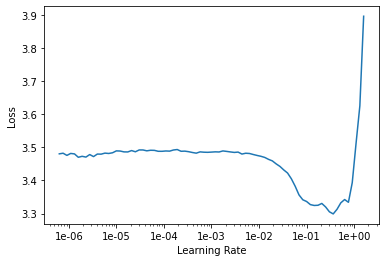

In [22]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [0]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

In [0]:
learn.save('first')
learn.save('../drive/My Drive/wine_reviews/models/region_classifier/first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [0]:
learn.save('second')
learn.save('../drive/My Drive/wine_reviews/models/region_classifier/second')

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [0]:
learn.save('third')
learn.save('../drive/My Drive/wine_reviews/models/region_classifier/third')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [0]:
learn.save('fourth')

In [0]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

In [0]:
learn.save('fifth')
learn.save('../drive/My Drive/wine_reviews/models/region_classifier/fifth')

In [0]:
#also save databunches for future use 
# data_clas.save('drive/My Drive/wine_reviews/data/region_clas_data_clas')

# Test Model

In [25]:
learn.predict('this is a dry, bitter wine')

(Category France - Alsace,
 tensor(0),
 tensor([5.7692e-01, 1.9461e-03, 1.2741e-01, 2.5976e-03, 4.4801e-02, 2.3713e-02,
         3.4923e-05, 6.1849e-02, 7.2134e-02, 7.7308e-04, 5.5331e-02, 8.8631e-05,
         2.0241e-05, 4.0747e-05, 4.8424e-04, 1.3826e-04, 2.2194e-05, 5.3940e-05,
         1.4177e-04, 6.0245e-04, 2.8054e-02, 4.3459e-05, 3.2940e-05, 3.3658e-05,
         1.2115e-03, 1.3079e-05, 1.5121e-03]))

In [26]:
learn.predict('red wine with a hint of berry and citrus')

(Category Italy - Northeastern Italy,
 tensor(14),
 tensor([1.2822e-03, 2.1342e-06, 1.2651e-03, 8.7199e-04, 2.6925e-05, 7.9763e-05,
         7.2828e-05, 5.1413e-05, 2.7509e-05, 5.4479e-04, 5.7838e-05, 6.5310e-02,
         5.3984e-03, 1.0518e-02, 4.8039e-01, 2.7930e-03, 5.5781e-02, 2.2459e-03,
         5.0514e-02, 9.6038e-02, 1.3079e-01, 1.0485e-02, 1.4978e-04, 2.0840e-03,
         4.8494e-02, 1.6873e-03, 3.3046e-02]))

In [27]:
learn.predict('sour and dry, with distinct strawberry flavours')

(Category US - California,
 tensor(20),
 tensor([3.0949e-02, 2.7768e-04, 4.3646e-04, 7.9019e-04, 6.6838e-03, 2.4096e-03,
         1.9106e-04, 2.1472e-03, 1.8618e-03, 4.7746e-04, 4.4067e-04, 1.4697e-04,
         1.0403e-04, 7.4829e-05, 2.3777e-04, 3.6213e-04, 3.6749e-05, 2.9711e-05,
         2.3654e-04, 7.3719e-04, 9.3081e-01, 3.1721e-04, 4.2827e-04, 7.7499e-03,
         7.0555e-03, 4.9932e-04, 4.5065e-03]))

Model performance could probably be improved but is good enough for our use case. 

In addition the predictions on the above examples suggest that we can already start to attribute certain flavours and attributes to certain regions.